In [1]:
%matplotlib inline
# !apt-get update
# !apt-get install -y libsndfile1
# !pip install librosa
# %pip install torchinfo


DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__


In [2]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

from __future__ import print_function

import os
import random
from glob import glob

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
# from torchinfo import summary
from IPython.display import HTML
from torch.utils.data import Dataset

from pre_process import *

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [3]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 51

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 200

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 1

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
train_data = glob("data/train/*.wav")
test_data = glob("data/test/*.wav")
unlabel_data = glob("data/unlabeled/*.wav")

train_df = pd.read_csv("data/train_data.csv")
test_df = pd.read_csv("data/test_data.csv")

In [5]:
# Decide which device we want to run on
if torch.cuda.is_available(): device = "cuda:0"
elif torch.has_mps: device = "mps"
else: device = "cpu"
device

'cuda:0'

In [6]:
# iloc[:, 5:]

class DataGen(Dataset):
    def __init__(self, data, df, is_train=True, only_img=False):
        if not is_train:
            self.x_data = np.array(data.iloc[:, 5:])
            self.x_df = np.array(df.iloc[:, :5])
            pass
        else:
            self.x_data = np.array(data.iloc[:, 6:])
            self.x_df = np.array(df.iloc[:, :6])
            self.y = df["covid19"]
        self.is_train = is_train
        self.only_img = only_img

    def __getitem__(self, index):
        if self.is_train:
            if self.only_img: return torch.tensor(self.x_data[index]).view(1, 32), torch.tensor(self.y[index]) #zero_pad(mfcc(get_melspectogram(self.x_data[index])))
            else: return torch.tensor(self.x_data[index]).view(1, 32), torch.tensor(self.x_df[index]), torch.tensor(self.y[index]) #zero_pad(mfcc(get_melspectogram(self.x_data[index])), self.x_df[index], self.y[index])
        else:
            if self.only_img: return torch.tensor(self.x_data[index]).view(1, 32)
            else: return torch.tensor(self.x_data[index]).view(1, 32), torch.tensor(self.x_df[index])

    def __len__(self):
        return len(self.x_data)

In [7]:
dataset = DataGen(data=pd.read_csv("data/train_mfcc_data.csv"), df=train_df, only_img=True)
test_dataset = DataGen(data=pd.read_csv("data/test_mfcc_data.csv"), df=test_df, is_train=False, only_img=True)

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)
# next(iter(dataloader))

In [8]:
# dataiter = iter(dataloader)
# dataiter.__next__()
# next(iter(dataloader)).shape

In [9]:
next(iter(dataset))[0]#.shape

tensor([[-2.7493e+02,  2.9345e+01, -1.9153e+01, -7.8369e+00, -9.0941e+00,
         -8.5535e+00, -3.2654e+01, -1.2341e+01, -5.1518e+00,  2.6698e+00,
         -7.8654e+00,  1.0571e+01,  2.8873e+00,  4.5172e+00, -8.1871e+00,
         -4.5959e-01, -6.6418e+00, -6.7001e-01, -4.5058e+00, -1.1374e+00,
         -3.0701e-01,  2.1264e+00, -2.3209e+00,  2.1500e+00, -9.2542e-01,
          2.1160e+00, -1.9273e-01,  2.4178e+00, -4.7367e+00,  1.2378e+00,
         -1.6004e+00, -1.4624e+00]], dtype=torch.float64)

Implementation
--------------

With our input parameters set and the
 prepared, we can now get
into the implementation. We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

Weight Initialization
~~~~~~~~~~~~~~~~~~~~~

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose1d(nz, ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose1d(ngf * 8, ngf * 4, 1, 2, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose1d( ngf * 4, ngf * 2, 1, 2, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose1d( ngf * 2, ngf, 1, 2, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose1d(ngf, nc, 1, 2, bias=False),
            nn.Linear(nc, 32),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [12]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(200, 256, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(256, 128, kernel_size=(1,), stride=(2,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(128, 64, kernel_size=(1,), stride=(2,), bias=False)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose1d(64, 32, kernel_size=(1,), stride=(2,), bias=False)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose1d(32, 1, kernel_size=(1,), stride=(2,), bias=False)
    (13): Linear(in_features=1, out_features=32, bias=True)
    (14): Sigmoid()
  )
)


In [13]:
torch.save(netG, "netG.pt")
# netD.load_state_dict()
# !pip install torchinfo
# summary(netG, (1, 220))

Discriminator
~~~~~~~~~~~~~

As mentioned, the discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
$G$ and $D$.




Discriminator Code



In [14]:
# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv1d(nc, ndf, 2, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf, ndf * 2, 2, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf * 2, ndf * 4, 2, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf * 4, ndf * 8, 2, 2, 1, bias=False),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(ndf * 8, 2, 3, 1, 0, bias=False),
            nn.Conv1d(2, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [15]:
device

'cuda:0'

In [16]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device == 'cuda' or device == 'mps') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 1, kernel_size=(2,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(1, 2, kernel_size=(2,), stride=(2,), padding=(1,), bias=False)
    (3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv1d(2, 4, kernel_size=(2,), stride=(2,), padding=(1,), bias=False)
    (6): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(4, 8, kernel_size=(2,), stride=(2,), padding=(1,), bias=False)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv1d(8, 2, kernel_size=(3,), stride=(1,), bias=False)
    (12): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
    (13): Sigmoid()
  )
)


In [17]:
torch.save(netD, "netD.pt")
# summary(netD, (1, 128, 2200))

In [18]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, 200, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.NAdam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.NAdam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
fixed_noise.shape

torch.Size([200, 200, 1])

In [20]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loopx...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device).float()
        b_size = real_cpu.size(0)
        label = data[1] #torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = label.type(torch.FloatTensor).to(device)

        # print("real cpu: ", real_cpu.shape)
        # print("label: ", label.shape)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch

        # print("output: ", output.shape)

        errD_real = criterion(output, label)

        # print("errD_real: ", errD_real)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 200, 1, device=device)

        # print("noise: ", noise.shape)

        # Generate fake image batch with G
        fake = netG(noise)

        # print("fake", fake.to('cpu').detach().numpy().shape)

        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # print("output", output)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # print("errG", errG)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loopx...
[0/2][0/238]	Loss_D: 1.6547	Loss_G: 0.5687	D(x): 0.5665	D(G(z)): 0.5663 / 0.5663
[0/2][50/238]	Loss_D: 1.6173	Loss_G: 0.5780	D(x): 0.5617	D(G(z)): 0.5612 / 0.5610
[0/2][100/238]	Loss_D: 1.6100	Loss_G: 0.5943	D(x): 0.5536	D(G(z)): 0.5522 / 0.5519
[0/2][150/238]	Loss_D: 1.5389	Loss_G: 0.6199	D(x): 0.5407	D(G(z)): 0.5383 / 0.5380
[0/2][200/238]	Loss_D: 1.4676	Loss_G: 0.6555	D(x): 0.5222	D(G(z)): 0.5197 / 0.5192
[1/2][0/238]	Loss_D: 1.4084	Loss_G: 0.6894	D(x): 0.5086	D(G(z)): 0.5023 / 0.5019
[1/2][50/238]	Loss_D: 1.2948	Loss_G: 0.7459	D(x): 0.4781	D(G(z)): 0.4750 / 0.4743
[1/2][100/238]	Loss_D: 1.1903	Loss_G: 0.8149	D(x): 0.4470	D(G(z)): 0.4435 / 0.4427
[1/2][150/238]	Loss_D: 1.1097	Loss_G: 0.9000	D(x): 0.4134	D(G(z)): 0.4074 / 0.4066
[1/2][200/238]	Loss_D: 0.9345	Loss_G: 0.9973	D(x): 0.3765	D(G(z)): 0.3699 / 0.3689


Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




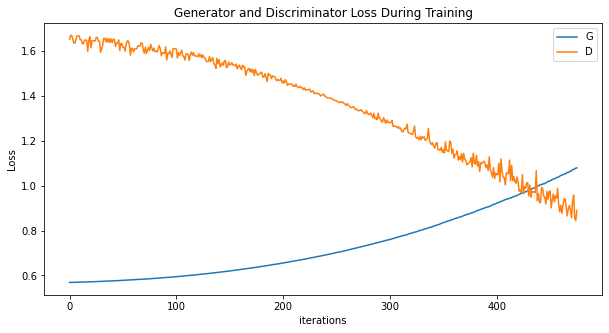

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio/>`__



In [22]:
# test_data = torch.Tensor(np.array(pd.read_csv("data/test_mfcc_data.csv").iloc[:, 5:]).reshape(-1, 1, 32))

netD(next(iter(test_dataloader)).to(device).float()).view(-1)

tensor([0.3477, 0.3548, 0.3342, 0.3442, 0.3375, 0.3564, 0.3687, 0.3611, 0.3448,
        0.3435, 0.3308, 0.3314, 0.3528, 0.3497, 0.3434, 0.3385],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [23]:
# pd.read_csv("data/train_mfcc_data.csv")

# next(iter(test_dataloader))
answer = []
for i in test_dataloader:
    for j in netD(i.to(device).float()).view(-1):
        answer.append(j.item())

In [41]:
answer_df = pd.DataFrame(answer)

print(answer_df[answer_df[0] >= 0.39])
answer_df[answer_df[0] >= 0.4] = 1
answer_df[answer_df[0] < 0.4] = 0

             0
27    0.421207
56    0.424079
69    0.422782
124   0.412345
135   0.393199
...        ...
5347  0.396105
5417  0.411506
5495  0.436640
5531  0.417677
5562  0.423707

[68 rows x 1 columns]


In [42]:
submit = pd.read_csv("data/sample_submission.csv")

submit['covid19'] = answer_df[0]
submit = submit.astype({'covid19': 'int'})
submit.to_csv("submission.csv", index=False)
# submit

In [44]:
submit[submit['covid19'] >= 0.39]

,id,covid19
27,3833,1
56,3862,1
69,3875,1
124,3930,1
237,4043,1
310,4116,1
483,4289,1
534,4340,1
667,4473,1
711,4517,1


In [37]:
df = pd.read_csv("MLP (100, 100, 100).csv")
df[df['covid19'] == 1]

,id,covid19
18,3824,1
75,3881,1
288,4094,1
289,4095,1
531,4337,1
...,...,...
5366,9172,1
5429,9235,1
5443,9249,1
5669,9475,1
